# Data Cleaning
- Remove duplicate columns, and columns with only a unique value from the pd.Dataframe

# Example 1
- Remove duplicate SMILES

In [83]:
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
import numpy as np
import rdkit.Chem as Chem

In [84]:
df=pd.read_csv(r"Data\123Benzothiadiazole_smiles.csv")
df.head()

,SMILES
0,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C
1,CCN1CCN(CCOC)c2c1cc1nsnc1c2C
2,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C
3,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21
4,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C


# Check for duplicate SMILES

In [85]:
# There might be one or more valid SMILES that can represent one compound
def canonical_smiles(smi):
    """
    canonical_smiles(smi) will return a standardised smiles
    """
    mol = Chem.MolFromSmiles(smi)
    smiles = Chem.MolToSmiles(mol)
    return smiles

In [86]:
df["SMILES"]=df["SMILES"].apply(lambda x:canonical_smiles(x))

In [87]:
# Create a list for duplicate smiles
duplicates_smiles = df[df['SMILES'].duplicated()]['SMILES'].values
print(len(duplicates_smiles))

39


# Drop duplicate SMILESs

In [88]:
print(f"Before: df.shape={df.shape}")
df = df.drop_duplicates(subset=['SMILES'])
print(f"After: df.shape={df.shape}")
df.index=np.arange(len(df))

Before: df.shape=(1569, 1)
After: df.shape=(1530, 1)


# Check for missing data

In [89]:
columns_with_nan=df.columns[df.isna().any()]
len(columns_with_nan)

0

# Remove columns with all values = 0

In [90]:
# Remove columns with all 0
print(f"Before: df.shape={df.shape}")
df=df.drop(df.columns[df.eq(0).all()],axis=1)
print(f"After: df.shape={df.shape}")

Before: df.shape=(1530, 1)
After: df.shape=(1530, 1)


In [91]:
# Remove duplicates
print(f"Before: df.shape={df.shape}")
df=df.loc[:,~df.columns.duplicated()].copy()
print(f"After: df.shape={df.shape}")

Before: df.shape=(1530, 1)
After: df.shape=(1530, 1)


# Drop columns with identical values

In [92]:
print(f"Before: df.shape={df.shape}")
df=df.loc[:,df.nunique()>1]
print(f"After: df.shape={df.shape}")

Before: df.shape=(1530, 1)
After: df.shape=(1530, 1)


# Example 2
- Generate RDkit decriptors and clean its pd.Dataframe

In [93]:
def RDkit_descriptors(smiles):
    """
    Function will return all 208 RDKit descriptors
    smiles is a pandas series or a list of smiles
    """
    from rdkit.ML.Descriptors import MoleculeDescriptors
    from rdkit.Chem import Descriptors
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 208 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

In [94]:
Mol_descriptors,desc_names = RDkit_descriptors(smiles=df["SMILES"])
df_rdkit = pd.DataFrame(Mol_descriptors,columns=desc_names)

In [95]:
print(f"df_rdkit.shape={df_rdkit.shape}")
df_rdkit.head()

df_rdkit.shape=(1530, 208)


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,8.673164,-4.313692,8.673164,0.278641,0.861773,291.424,270.256,291.151767,108,0,0.109421,-0.371076,0.371076,0.109421,1.550000,2.500000,3.300000,1.460045e-15,-0.246537,-2.572833e-17,-2.722027,-1.166959e-16,-2.828997,4.401419e-16,-1.048429,2.676061,1319.710561,32.317473,30.644316,10.460813,17.869915,15.574823,5.805120,3.612095,4.140543,2.417668,2.946116,1.611669,2.125660,-1.40,1.083990e+08,3.329290,5.179478,2.226066,153.172494,14.699729,11.033401,0.000000,0.0,0.0,0.0,0.0,0.0,8.74708,0.0,0.000000,26.845965,57.717337,32.698270,28.785930,34.136361,0.0,13.64699,0.0,6.851892,56.714739,11.605870,0.0,0.0,9.799819,11.374773,0.0,11.728187,60.561909,0.000000,6.851892,34.349381,6.042419,0.000000,11.033401,0.0,35.50,97.580675,0.0,0.0,4.899910,11.728187,0.0,0.0,0.0,0.0,8.747080,28.785930,177.855130,0.330538,-1.645123,0.000000,-5.035603,0.0,-1.044342,0.00000,-31.627267,0.000000,0.571429,20,0,5,0,1,1,1,1,2,6,0,6,7,0,0,0,3,1.81752,86.1890,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,5,0,0,0,2,0,0,0,0,0,0,0,0,0,2,1,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8.626172,-4.129610,8.626172,0.326009,0.864637,292.408,272.248,292.135782,108,0,0.109421,-0.382853,0.382853,0.109421,1.550000,2.500000,3.350000,4.819916e-15,-0.248509,-2.855418e-17,-2.715352,-3.770785e-17,-2.810480,5.445269e-16,-1.039085,2.689828,1309.444040,31.447229,29.605351,10.421848,17.460996,15.062251,5.792548,3.480809,4.009257,2.464343,2.992790,1.663987,2.177978,-1.40,7.818057e+07,3.495314,5.535354,2.125124,151.1

In [96]:
# Remove columns with all 0
print(f"Before: df_rdkit.shape={df_rdkit.shape}")
df_rdkit=df_rdkit.drop(df_rdkit.columns[df_rdkit.eq(0).all()],axis=1)
print(f"After: df_rdkit.shape={df_rdkit.shape}")

Before: df_rdkit.shape=(1530, 208)
After: df_rdkit.shape=(1530, 123)


In [97]:
# Remove duplicates columns
print(f"Before: df_rdkit.shape={df_rdkit.shape}")
df_rdkit=df_rdkit.loc[:,~df_rdkit.columns.duplicated()].copy()
print(f"After: df_rdkit.shape={df_rdkit.shape}")

Before: df_rdkit.shape=(1530, 123)
After: df_rdkit.shape=(1530, 123)


In [98]:
# Drop columns which contain identical values
print(f"Before: df_rdkit.shape={df_rdkit.shape}")
df_rdkit=df_rdkit.loc[:,df_rdkit.nunique()>1]
print(f"After: df_rdkit.shape={df_rdkit.shape}")

Before: df_rdkit.shape=(1530, 123)
After: df_rdkit.shape=(1530, 115)


In [99]:
print(f"df_rdkit.shape={df_rdkit.shape}")
# count numeric features
print(f"df_rdkit._get_numeric_data().shape={df_rdkit._get_numeric_data().shape}")


df_rdkit.shape=(1530, 115)
df_rdkit._get_numeric_data().shape=(1530, 115)


# All features in df_rdkit are numeric

In [100]:
df_rdkit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1530 entries, 0 to 1529
Columns: 115 entries, MaxEStateIndex to fr_methoxy
dtypes: float64(93), int64(22)
memory usage: 1.3 MB


# Check skewness in all features and do box-cox transform

In [101]:
df_rdkit_sw=df_rdkit.copy()

In [102]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

numeric_feats = df_rdkit_sw.dtypes[df_rdkit_sw.dtypes != "object"].index
# Xdata_btz._get_numeric_data()

# Check the skew of all numerical features
skewed_feats = df_rdkit_sw[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
PEOE_VSA2,27.604371
PEOE_VSA13,9.327981
EState_VSA4,8.358891
SMR_VSA3,8.158434
BCUT2D_MWLOW,7.750647
Ipc,7.463852
BCUT2D_LOGPHI,6.181564
BCUT2D_CHGHI,6.000701
PEOE_VSA14,4.886799
PEOE_VSA3,4.154648


In [103]:
skewness = skewness[abs(skewness) > 0.75].dropna()
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
print(skewness.isna().any())
transformed_features=[]
skewed_features = skewness.index
for feat in skewed_features:
    if all(df_rdkit[feat]>0):
        transformed_features.append(feat)
        df_rdkit_sw[feat],_ = stats.boxcox(df_rdkit_sw[feat])

There are 52 skewed numerical features to Box Cox transform
Skew    False
dtype: bool


In [104]:
df_rdkit_sw.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,TPSA,EState_VSA1,EState_VSA10,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_NH0,fr_NH1,fr_Ndealkylation1,fr_aniline,fr_aryl_methyl,fr_bicyclic,fr_ether,fr_methoxy
0,0.117313,-4.313692,0.117313,0.278641,-0.112879,291.424,270.256,291.151767,108,-12.570185,-0.371076,-0.768775,-12.570185,1.550000,7.802324,40.568904,1.460045e-15,-0.246537,-2.572833e-17,-2.722027,-1.166959e-16,-2.828997,4.401419e-16,-1.048429,2.676061,1319.710561,32.317473,30.644316,10.460813,17.869915,15.574823,5.805120,3.612095,4.140543,2.417668,2.946116,1.611669,2.125660,-1.40,11.133287,3.329290,5.179478,2.226066,153.172494,14.699729,11.033401,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,26.845965,57.717337,32.698270,28.785930,34.136361,0.006396,0.0,6.851892,56.714739,11.605870,0.0,9.799819,11.374773,0.0,60.561909,0.000000,6.851892,4.353949,6.042419,0.000000,2.217578,97.580675,0.0,4.899910,11.728187,0.0,0.044855,28.785930,177.855130,0.330538,-1.645123,0.000000,-5.035603,0.0,-1.044342,0.00000,-31.627267,0.000000,0.571429,20,0,5,0,1,1,6,0,6,7,0,0,0.998668,1.81752,86.1890,5,0,2,2,1,0.648095,0,0
1,0.117313,-4.129610,0.117313,0.326009,-0.111010,292.408,272.248,292.135782,108,-12.570184,-0.382853,-0.750268,-12.570184,1.550000,7.802324,43.317027,4.819916e-15,-0.248509,-2.855418e-17,-2.715352,-3.770785e-17,-2.810480,5.445269e-16,-1.039085,2.689828,1309.444040,31.447229,29.605351,10.421848,17.460996,15.062251,5.792548,3.480809,4.009257,2.464343,2.992790,1.663987,2.177978,-1.40,11.025502,3.495314,5.535354,2.125124,151.121235,14.536682,11.033401,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,19.746203,49.554911,46.111048,32.152034,34.136361,0.006396,0.0,13.703784,49.384196,11.605870,0.0,9.799819,11.374773,0.0,48.331456,4.736863,6.851892,4.577212,6.042419,0.000000,2.271365,92.202115,0.0,4.899910,11.728187,0.0,0.044855,27.415171,173.064066,0.326009,-0.794484,0.000000,-5.106135,0.0,-1.085786,0.00000,-27.419774,-3.650562,0.571429,20,0,5,0,1,1,6,0,6,7,0,0,0.998668,2.29242,84.1280,4,0,1,2,1,0.648095,1,1
2,0.117313,-4.210035,0.117313,0.276514,-0.053463,291.424,270.256,291.151767,108,-7.403229,-0.381730,-0.752021,-7.403229,1.700000,9.750231,49.238920,1.471424e-15,-0.249134,-1.016592e-17,-2.726273,-5.790277e-17,-2.801322,6.667871e-16,-1.072492,2.806412,1321.710561,32.317473,30.644316,10.460813,17.914573,15.548430,5.831513,3.598899,4.127346,2.510373,3.038821,1.736514,2.245686,-1.56,11.194401,3.265986,5.086989,1.984487,153.020579,15.109633,11.033401,1.411842,0.0,0.0,0.0,0.0,0.0,0.000000,26.598095,51.674918,37.014898,28.827013,39.823748,0.006396,0.0,26.573569,41.576039,6.042419,0.0,15.109633,17.062159,0.0,41.231378,0.000000,0.000000,4.863027,6.042419,1.411842,2.293176,97.387677,0.0,16.628097,0.000000,0.0,0.044855,28.827013,177.905855,0.276514,-0.796103,-0.455229,-5.441940,0.0,-5.298666,0.00000,-27.357098,0.000000,0.571429,20,1,5,0,1,1,6,1,6,7,0,0,0.998668,2.787

***Some columns in df_rdkit_sw have NaN, because of the log of negative in the original df_rdkit_sw***

In [105]:
df_rdkit.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,TPSA,EState_VSA1,EState_VSA10,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_NH0,fr_NH1,fr_Ndealkylation1,fr_aniline,fr_aryl_methyl,fr_bicyclic,fr_ether,fr_methoxy
0,8.673164,-4.313692,8.673164,0.278641,0.861773,291.424,270.256,291.151767,108,0.109421,-0.371076,0.371076,0.109421,1.550000,2.500000,3.300000,1.460045e-15,-0.246537,-2.572833e-17,-2.722027,-1.166959e-16,-2.828997,4.401419e-16,-1.048429,2.676061,1319.710561,32.317473,30.644316,10.460813,17.869915,15.574823,5.805120,3.612095,4.140543,2.417668,2.946116,1.611669,2.125660,-1.40,1.083990e+08,3.329290,5.179478,2.226066,153.172494,14.699729,11.033401,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,26.845965,57.717337,32.698270,28.785930,34.136361,13.64699,0.0,6.851892,56.714739,11.605870,0.0,9.799819,11.374773,0.0,60.561909,0.000000,6.851892,34.349381,6.042419,0.000000,35.50,97.580675,0.0,4.899910,11.728187,0.0,8.747080,28.785930,177.855130,0.330538,-1.645123,0.000000,-5.035603,0.0,-1.044342,0.00000,-31.627267,0.000000,0.571429,20,0,5,0,1,1,6,0,6,7,0,0,3,1.81752,86.1890,5,0,2,2,1,2,0,0
1,8.626172,-4.129610,8.626172,0.326009,0.864637,292.408,272.248,292.135782,108,0.109421,-0.382853,0.382853,0.109421,1.550000,2.500000,3.350000,4.819916e-15,-0.248509,-2.855418e-17,-2.715352,-3.770785e-17,-2.810480,5.445269e-16,-1.039085,2.689828,1309.444040,31.447229,29.605351,10.421848,17.460996,15.062251,5.792548,3.480809,4.009257,2.464343,2.992790,1.663987,2.177978,-1.40,7.818057e+07,3.495314,5.535354,2.125124,151.121235,14.536682,11.033401,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,19.746203,49.554911,46.111048,32.152034,34.136361,8.74708,0.0,13.703784,49.384196,11.605870,0.0,9.799819,11.374773,0.0,48.331456,4.736863,6.851892,39.830515,6.042419,0.000000,41.49,92.202115,0.0,4.899910,11.728187,0.0,13.483943,27.415171,173.064066,0.326009,-0.794484,0.000000,-5.106135,0.0,-1.085786,0.00000,-27.419774,-3.650562,0.571429,20,0,5,0,1,1,6,0,6,7,0,0,3,2.29242,84.1280,4,0,1,2,1,2,1,1
2,8.716621,-4.210035,8.716621,0.276514,0.941806,291.424,270.256,291.151767,108,0.160186,-0.381730,0.381730,0.160186,1.700000,2.650000,3.450000,1.471424e-15,-0.249134,-1.016592e-17,-2.726273,-5.790277e-17,-2.801322,6.667871e-16,-1.072492,2.806412,1321.710561,32.317473,30.644316,10.460813,17.914573,15.548430,5.831513,3.598899,4.127346,2.510373,3.038821,1.736514,2.245686,-1.56,1.308464e+08,3.265986,5.086989,1.984487,153.020579,15.109633,11.033401,1.411842,0.0,0.0,0.0,0.0,0.0,0.000000,26.598095,51.674918,37.014898,28.827013,39.823748,8.74708,0.0,26.573569,41.576039,6.042419,0.0,15.109633,17.062159,0.0,41.231378,0.000000,0.000000,47.970847,6.042419,1.411842,44.29,97.387677,0.0,16.628097,0.000000,0.0,8.747080,28.827013,177.905855,0.276514,-0.796103,-0.455229,-5.441940,0.0,-5.298666,0.00000,-27.357098,0.000000,0.571429,20,1,5,0,1,1,6,1,6,7,0,0,3,2.78770,87.3307,4,1,1,3,0,2,0,0
3,8.729323,-4.283244,8.72

# Check distribution of rdkit features

In [106]:
# Suppress FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

# Before

In [119]:
len(transformed_features)

15

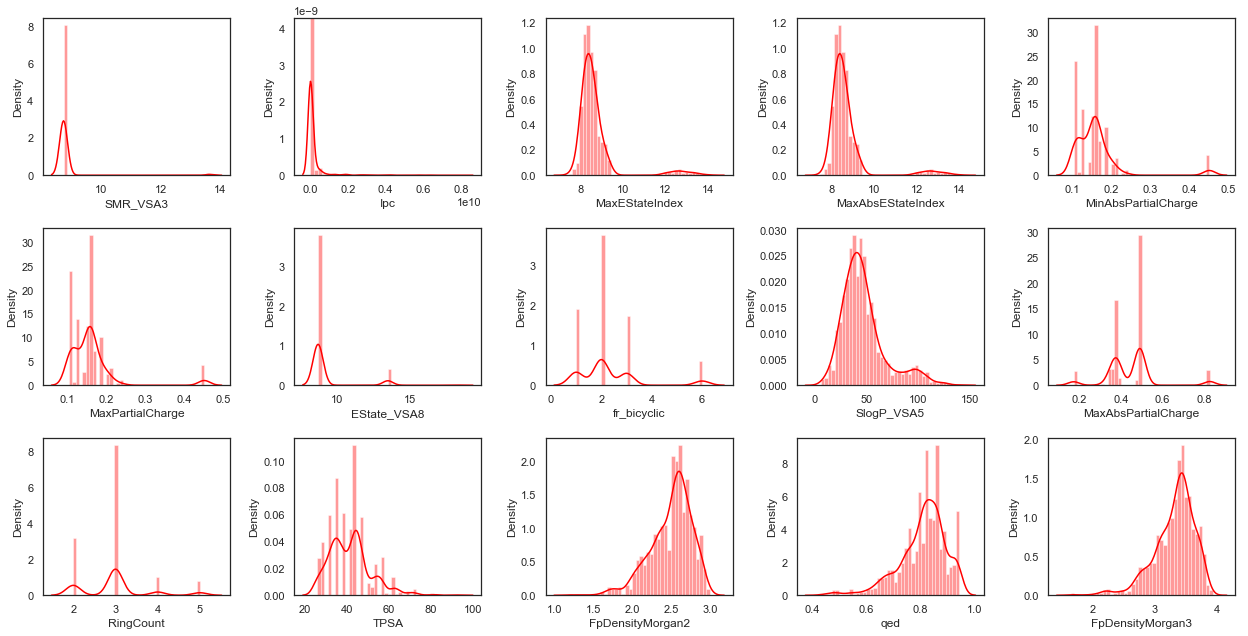

In [120]:
descriptors=transformed_features
from scipy.stats import norm
nr_rows = 3
nr_cols = 5
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        
        if i < len(descriptors):

            sns.distplot(x=df_rdkit[descriptors[i]],color="red", ax = axs[r][c],bins=40,kde=True)
            # sns.distplot(x=df_rdkit_sc[descriptors[i]],color="green", ax = axs[r][c],bins=40,kde=True)
            axs[r][c].set_xlabel(descriptors[i])
        else:
            fig.delaxes(axs[r][c])
            
plt.tight_layout()    
plt.show()  

# Cannot say that all features are now normally distributed after box cox transformation

Ref: https://www.geeksforgeeks.org/box-cox-transformation-using-python/

# Does Box-cox always work? The answer is NO. 

Box-cox does not guarantee normality because it never checks for the normality which is necessary to be foolproof that it has correctly transformed the non-normal distribution or not. It only checks for the smallest Standard deviation. 
Therefore, it is absolutely necessary to always check the transformed data for normality using a probability plot.

# Let's check one feature at a time

In [110]:
def probability_plt(des,df_before,df_after):
    import scipy.stats as stats
    plot , ax = plt.subplots(2 , 2 , figsize = (12 , 12))
    des=des
    bef,aft=df_before[des],df_after[des]
    g = sns.histplot( bef, kde = True , ax = ax[0][0])
    res = stats.probplot(bef, plot=ax[1][0])
    g = sns.histplot(aft, kde = True , ax = ax[0][1])
    res = stats.probplot(aft, plot= ax[1][1])
    ax[0][1].set_xlabel("Box Cox Transformed")
    plt.show()

In [121]:
descriptors=transformed_features

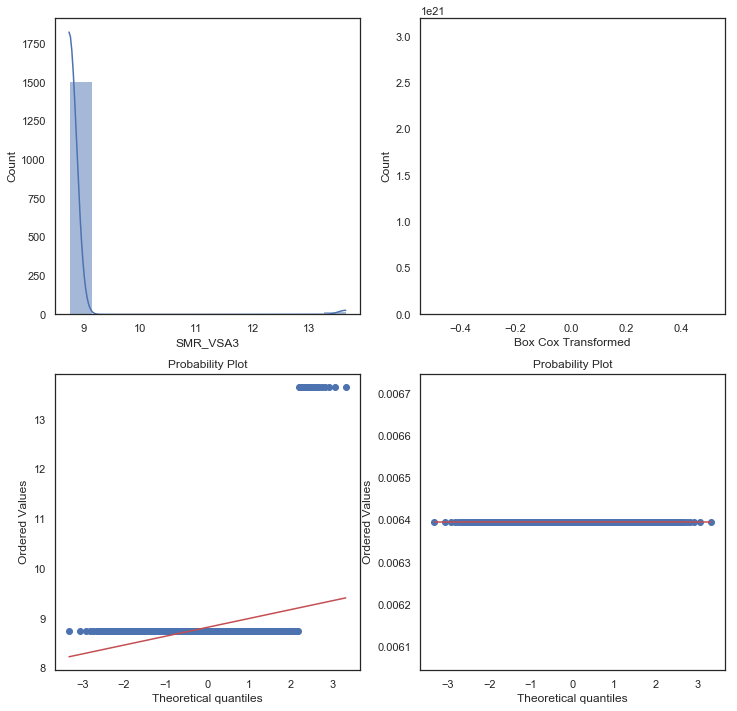

In [123]:
probability_plt(des=descriptors[0],df_before=df_rdkit,df_after=df_rdkit_sw)

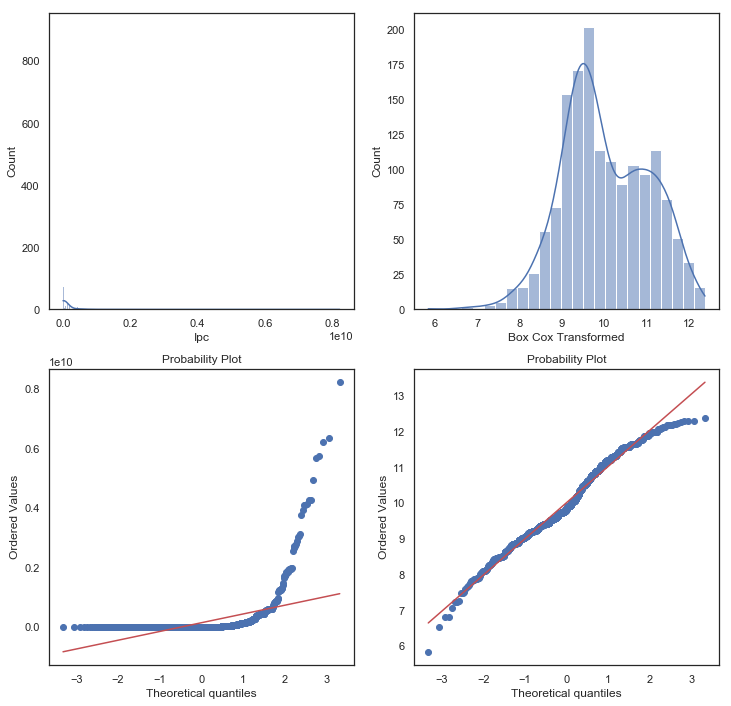

In [124]:
probability_plt(des=descriptors[1],df_before=df_rdkit,df_after=df_rdkit_sw)

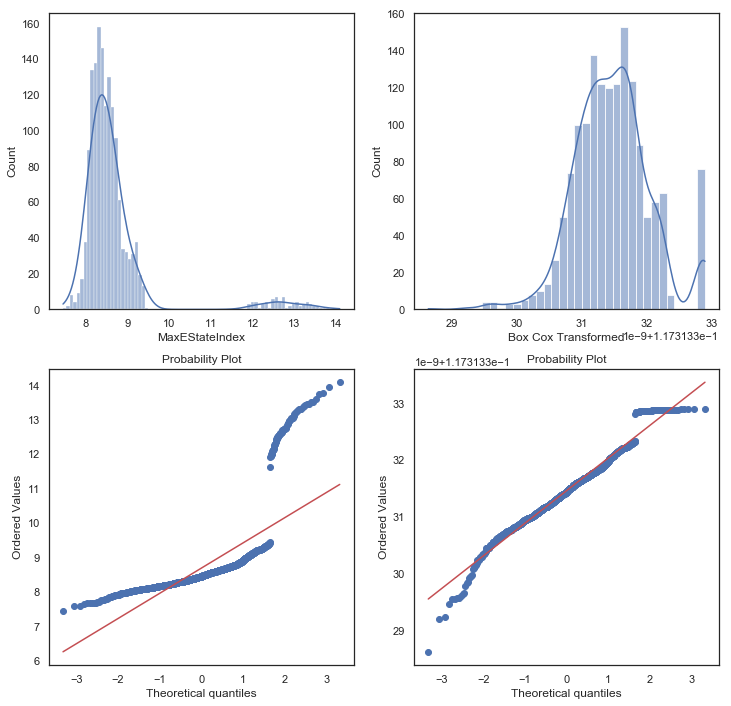

In [125]:
probability_plt(des=descriptors[2],df_before=df_rdkit,df_after=df_rdkit_sw)

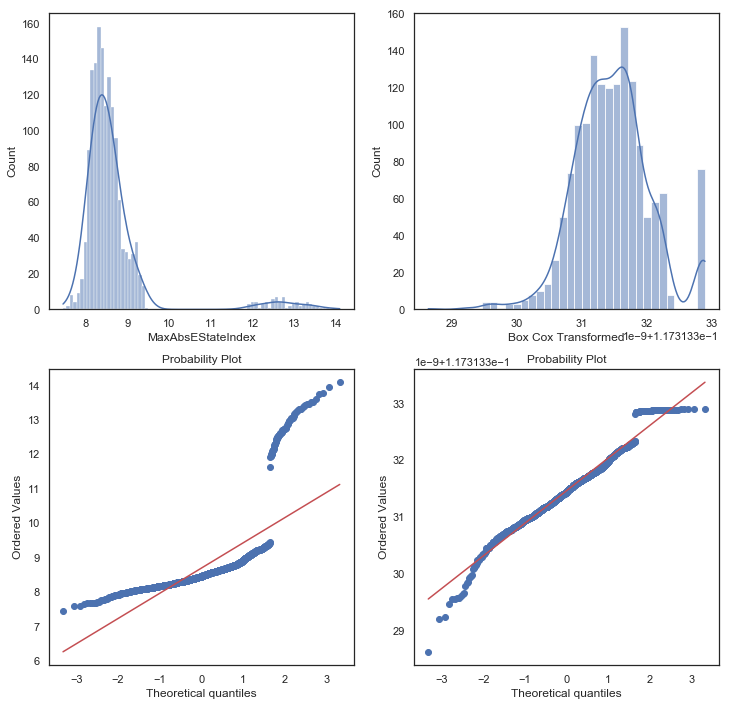

In [126]:
probability_plt(des=descriptors[3],df_before=df_rdkit,df_after=df_rdkit_sw)

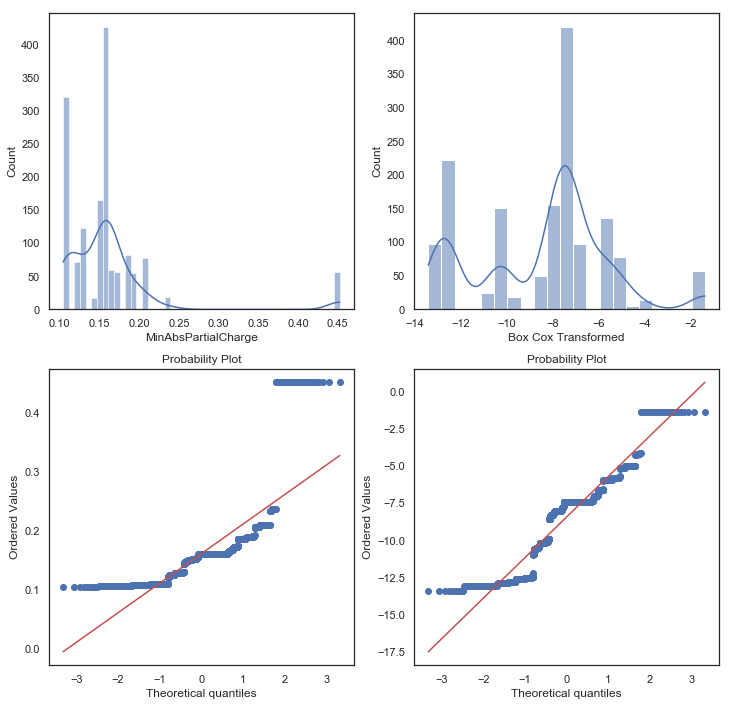

In [127]:
probability_plt(des=descriptors[4],df_before=df_rdkit,df_after=df_rdkit_sw)

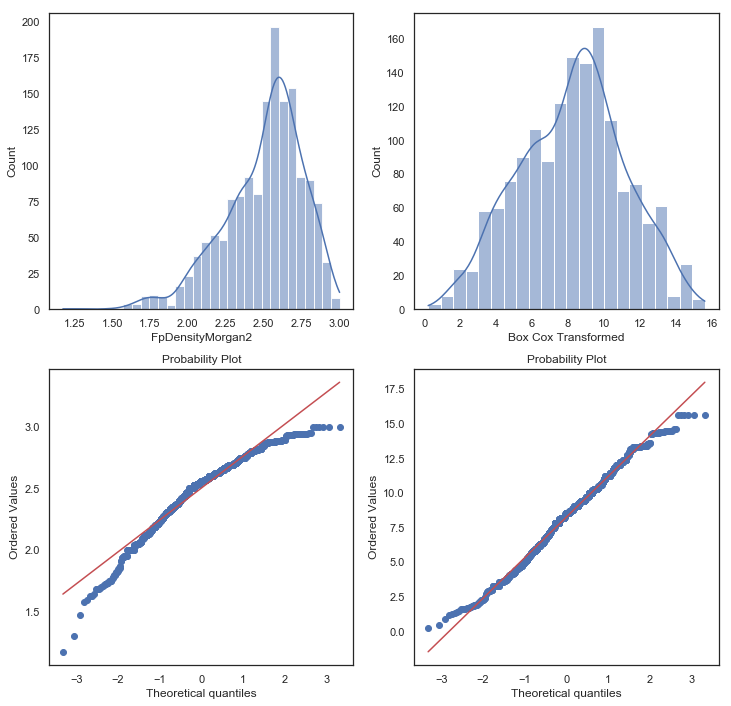

In [129]:
probability_plt(des=descriptors[-3],df_before=df_rdkit,df_after=df_rdkit_sw)

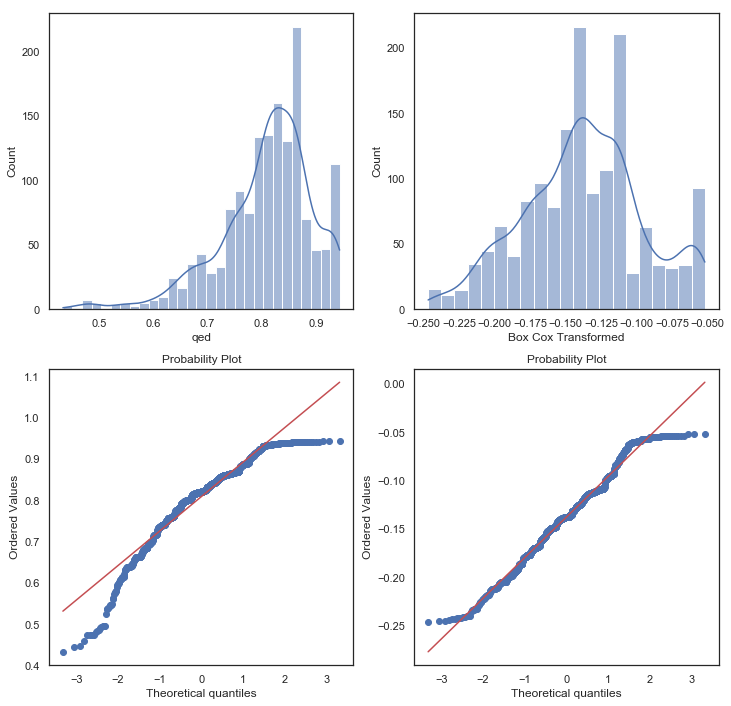

In [130]:
probability_plt(des=descriptors[-2],df_before=df_rdkit,df_after=df_rdkit_sw)

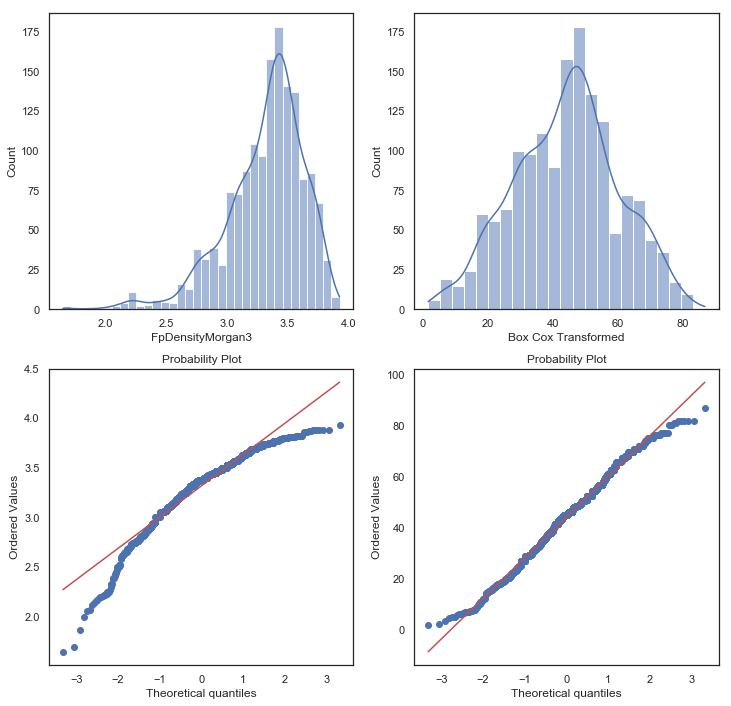

In [132]:
probability_plt(des=descriptors[-1],df_before=df_rdkit,df_after=df_rdkit_sw)

# Continuous features/variable become more normally distributed after the box cox transform